# CBV

 CBV project is a reliable and efficient system that can assist bridge inspectors in detecting defects with higher accuracy and speed than traditional methods By using Computer Vision Techniques and robust Detction Model.

In [ ]:
!pip install ultralytics
!pip install -q roboflow
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 14.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
import random
import matplotlib.pyplot as plt
import os
from roboflow import Roboflow
from PIL import Image
import numpy as np
from albumentations import Compose, HorizontalFlip, ShiftScaleRotate, RandomBrightnessContrast, BboxParams
import cv2
import shutil
!pip install torch
import torch
!pip install torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import glob
from IPython.display import Image, display
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
!pip install Pillow





In [ ]:

home = os.getcwd()
print(home)

/content


In [ ]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q



Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Total 325 (delta 0), reused 0 (delta 0), pack-reused 325
Receiving objects: 100% (325/325), 2.25 MiB | 39.04 MiB/s, done.
Resolving deltas: 100% (164/164), done.
/content/yolov9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.5 MB/s eta 0:00:00


In [ ]:
!wget -P {home}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {home}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {home}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {home}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt


In [ ]:
!ls -la {home}/weights

total 352008
drwxr-xr-x 2 root root      4096 Apr 19 16:26 .
drwxr-xr-x 1 root root      4096 Apr 19 16:26 ..
-rw-r--r-- 1 root root  51508261 Feb 18 12:36 gelan-c.pt
-rw-r--r-- 1 root root  51508261 Feb 18 12:36 gelan-c.pt.1
-rw-r--r-- 1 root root 117203713 Feb 18 12:36 gelan-e.pt
-rw-r--r-- 1 root root 140217688 Feb 18 12:36 yolov9-e.pt


# RoboFlow Dataset

The ”flaw-on-bridge” dataset is a specialized collection of images tailored for object detection in bridge inspections. It features a diverse range of images showcasing various
flaws commonly found in bridge structures. This dataset includes meticulous annotations for different classes of flaws, such as Bearing, Cover Plate, Termination, Gusset
Plate Connection, and Out of Plane Stiffener.

In [ ]:

rf = Roboflow(api_key="s0usIb1HAC6nEWOv2Kse")
project = rf.workspace("yolov7-phcjc").project("coco-bridge-k3any")
version = project.version(1)
dataset = version.download("yolov9")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to coco-bridge-1 in yolov9:: 100%|██████████| 2922/2922 [00:00<00:00, 9028.75it/s]


In [ ]:

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(np.array(img))
    return np.array(images)

def load_labels_from_folder(folder):
    labels = []
    for filename in os.listdir(folder):
        with open(os.path.join(folder, filename), 'r') as file:
            label = file.read().strip()
            labels.append(label)
    return np.array(labels)

In [ ]:
#Check Folder Contents
train_path = '/content/yolov9/coco-bridge-1/train'
test_path = '/content/yolov9/coco-bridge-1/test'
valid_path = '/content/yolov9/coco-bridge-1/valid'

# Check the contents to verify
print("Train folder contents:", os.listdir(train_path))
print("Test folder contents:", os.listdir(test_path))
print("Valid folder contents:", os.listdir(valid_path))


Train folder contents: ['images', 'labels']
Test folder contents: ['images', 'labels']
Valid folder contents: ['images', 'labels']


In [ ]:
# Paths to the image folders
train_images_folder = '/content/yolov9/coco-bridge-1/train/images'
test_images_folder = '/content/yolov9/coco-bridge-1/test/images'
valid_images_folder = '/content/yolov9/coco-bridge-1/valid/images'

# Load images
train_images = load_images_from_folder(train_images_folder)
test_images = load_images_from_folder(test_images_folder)
valid_images = load_images_from_folder(valid_images_folder)

# Check shapes
print("Train Images shape:", train_images.shape)
print("Test Images shape:", test_images.shape)
print("Valid Images shape:", valid_images.shape)

Train Images shape: (1187, 416, 416, 3)
Test Images shape: (136, 416, 416, 3)
Valid Images shape: (132, 416, 416, 3)


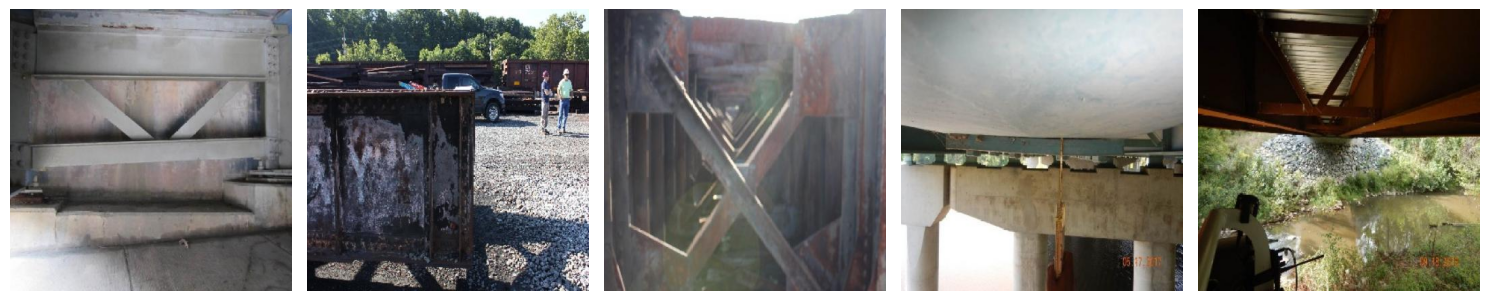

In [ ]:


train_images_path = '/content/yolov9/coco-bridge-1/train/images'
image_files = os.listdir(train_images_path)
num_images_to_plot = 5
selected_images = random.sample(image_files, num_images_to_plot)

plt.figure(figsize=(15, 10))
for i, image_name in enumerate(selected_images):
    image_path = os.path.join(train_images_path, image_name)
    image = Image.open(image_path)

    plt.subplot(1, num_images_to_plot, i+1)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()


# Preprocessing

In [ ]:
def resize_and_normalize(image, target_size=(416, 416)):

    resized_image = image.resize(target_size)
    np_image = np.array(resized_image)
    normalized_image = np_image / 255.0
    return normalized_image


In [ ]:
def load_images_from_folder(folder, target_size=(416, 416)):

    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        if img is not None:
            resized_and_normalized_img = resize_and_normalize(img, target_size)
            images.append(resized_and_normalized_img)
    return np.array(images)


In [ ]:
import cv2
import os
import shutil
from albumentations import Compose, HorizontalFlip, VerticalFlip, ShiftScaleRotate, RandomBrightnessContrast, BboxParams, GaussianBlur, HueSaturationValue

def get_transforms():
    # Multiple transformations for variety
    return [
        Compose([
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.2),
            ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, p=0.7),
            RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
        ], bbox_params=BboxParams(
            format='yolo',
            min_area=0.1,
            min_visibility=0.3,
            label_fields=['labels']
        )),
        Compose([
            GaussianBlur(blur_limit=(3, 7), sigma_limit=0.1, p=1),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1)
        ], bbox_params=BboxParams(
            format='yolo',
            min_area=0.1,
            min_visibility=0.3,
            label_fields=['labels']
        ))
    ]

def process_and_save(data_path, save_path, augment_data=True):
    images_path = os.path.join(data_path, 'images')
    labels_path = os.path.join(data_path, 'labels')

    os.makedirs(os.path.join(save_path, 'images'), exist_ok=True)
    os.makedirs(os.path.join(save_path, 'labels'), exist_ok=True)

    images = set([f for f in os.listdir(images_path) if f.endswith('.jpg')])
    labels = set([f.replace('.txt', '.jpg') for f in os.listdir(labels_path) if f.endswith('.txt')])

    valid_files = images.intersection(labels)

    for filename in valid_files:
        image_filename = filename
        label_filename = filename.replace('.jpg', '.txt')

        image_path = os.path.join(images_path, image_filename)
        image = cv2.imread(image_path)

        label_path = os.path.join(labels_path, label_filename)
        original_labels = []
        with open(label_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                original_labels.append([int(parts[0]), float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])])

        # Save original images and labels
        original_image_save_path = os.path.join(save_path, 'images', image_filename)
        original_label_save_path = os.path.join(save_path, 'labels', label_filename)
        cv2.imwrite(original_image_save_path, image)
        shutil.copy(label_path, original_label_save_path)

        if augment_data:
            for transform in get_transforms():
                transformed = transform(image=image, bboxes=[(x[1], x[2], x[3], x[4]) for x in original_labels], labels=[x[0] for x in original_labels])
                transformed_image = transformed['image']
                transformed_bboxes = transformed['bboxes']
                transformed_labels = transformed['labels']

                augmented_image_filename = f"aug_{transform.__hash__()}_{image_filename}"
                augmented_label_filename = f"aug_{transform.__hash__()}_{label_filename}"
                save_augmented_image_path = os.path.join(save_path, 'images', augmented_image_filename)
                save_augmented_label_path = os.path.join(save_path, 'labels', augmented_label_filename)
                cv2.imwrite(save_augmented_image_path, transformed_image)
                with open(save_augmented_label_path, 'w') as file:
                    for label, bbox in zip(transformed_labels, transformed_bboxes):
                        file.write(f"{label} {' '.join(map(str, bbox))}\n")

# Define paths
base_data_folder = "/content/yolov9/coco-bridge-1"
save_base_folder = "/content/CBV_Data"

# Process each dataset part
for part in ['train', 'test', 'valid']:
    data_path = os.path.join(base_data_folder, part)
    save_path = os.path.join(save_base_folder, part)
    process_and_save(data_path, save_path)


In [ ]:


def count_files(directory):
    image_files = [f for f in os.listdir(os.path.join(directory, 'images')) if f.endswith('.jpg')]
    label_files = [f for f in os.listdir(os.path.join(directory, 'labels')) if f.endswith('.txt')]

    print(f"In {directory}:")
    print(f"  Number of images: {len(image_files)}")
    print(f"  Number of labels: {len(label_files)}\n")


base_directory = "/content/CBV_Data"

# Parts to check (train, test, valid)
parts = ['train', 'test', 'valid']

# Loop through each part and print out the counts of images and labels
for part in parts:
    directory = os.path.join(base_directory, part)
    count_files(directory)


In /content/CBV_Data/train:
  Number of images: 3561
  Number of labels: 3561

In /content/CBV_Data/test:
  Number of images: 408
  Number of labels: 408

In /content/CBV_Data/valid:
  Number of images: 396
  Number of labels: 396



# Yolov9

In [ ]:
!python /content/yolov9/train.py \
--batch 16 --epochs 50 --img 416 --device 0 --min-items 0 --close-mosaic 15 \
--data /content/yolov9/coco-bridge-1/data.yaml\
--weights /content/weights/gelan-c.pt\
--cfg /content/yolov9/models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml


2024-04-19 16:29:44.142619: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 16:29:44.142667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 16:29:44.144054: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-19 16:29:45.182347: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=/content/weights/gelan-c.pt, cfg=/content/yolov9/models/detect/gelan-c.yaml, data=/content/yolov9/coco-bridge-1/data.yaml, hyp=hyp.scratch-high.yaml, epochs=50, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False,

In [ ]:
!ls /content/yolov9/runs/train/exp3

confusion_matrix.png				    PR_curve.png	   val_batch0_pred.jpg
events.out.tfevents.1713544185.40b5b56bce8f.2355.0  R_curve.png		   val_batch1_labels.jpg
F1_curve.png					    results.csv		   val_batch1_pred.jpg
hyp.yaml					    results.png		   val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg	   val_batch2_pred.jpg
labels.jpg					    train_batch1.jpg	   weights
opt.yaml					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


In [ ]:
import glob
from IPython.display import Image, display
# Get a random sample of images from the test folder
test_images_folder = '/content/CBV_Data/test/images'
image_files = os.listdir(test_images_folder)
num_images_to_check = 5
random_images = random.sample(image_files, num_images_to_check)

# Run YOLOv9 inference on the selected images
for image_name in random_images:
    image_path = os.path.join(test_images_folder, image_name)
    !python /content/yolov9/detect.py \
        --weights /content/yolov9/runs/train/exp3/weights/best.pt \
        --source {image_path} \
        --conf 0.5 \
        --img 416 \
        --device 0


detect: weights=['/content/yolov9/runs/train/exp3/weights/best.pt'], source=/content/CBV_Data/test/images/aug_8337246990583_50_jpeg.rf.e798b507281ea58c521ac48edeebe308.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25414044 parameters, 0 gradients, 102.5 GFLOPs
image 1/1 /content/CBV_Data/test/images/aug_8337246990583_50_jpeg.rf.e798b507281ea58c521ac48edeebe308.jpg: 416x416 1 Bearing, 1 Gusset Plate Connection, 30.2ms
Speed: 0.4ms pre-process, 30.2ms inference, 471.2ms NMS per image at shape (1, 3, 416, 416)
Results

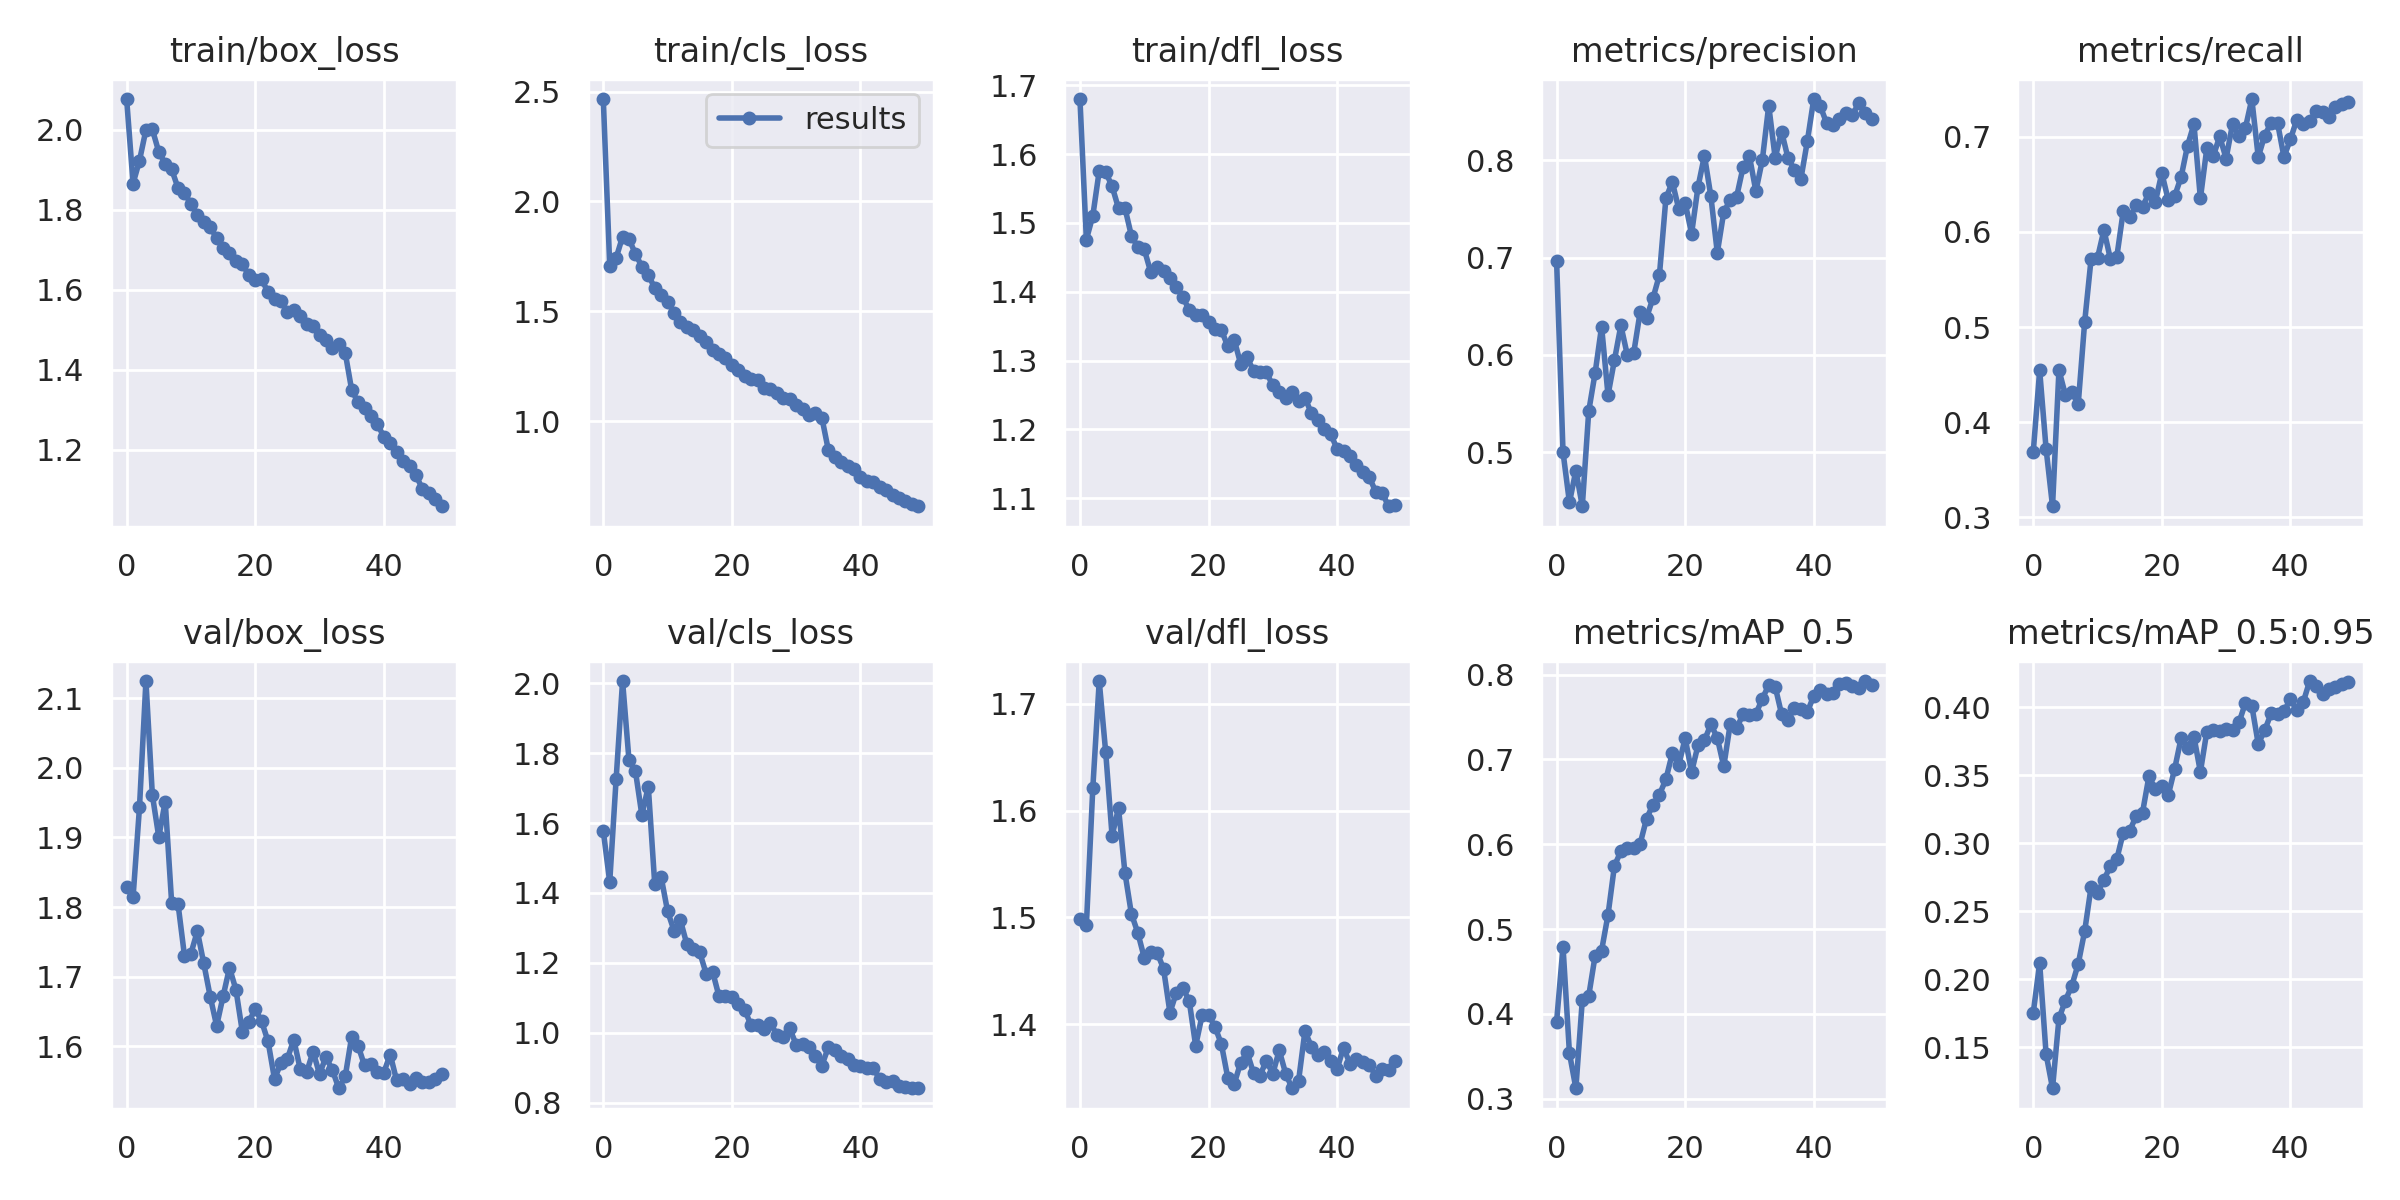

In [ ]:
import glob
from IPython.display import Image, display
Image(filename=f"/content/yolov9/runs/train/exp3/results.png", width=700)

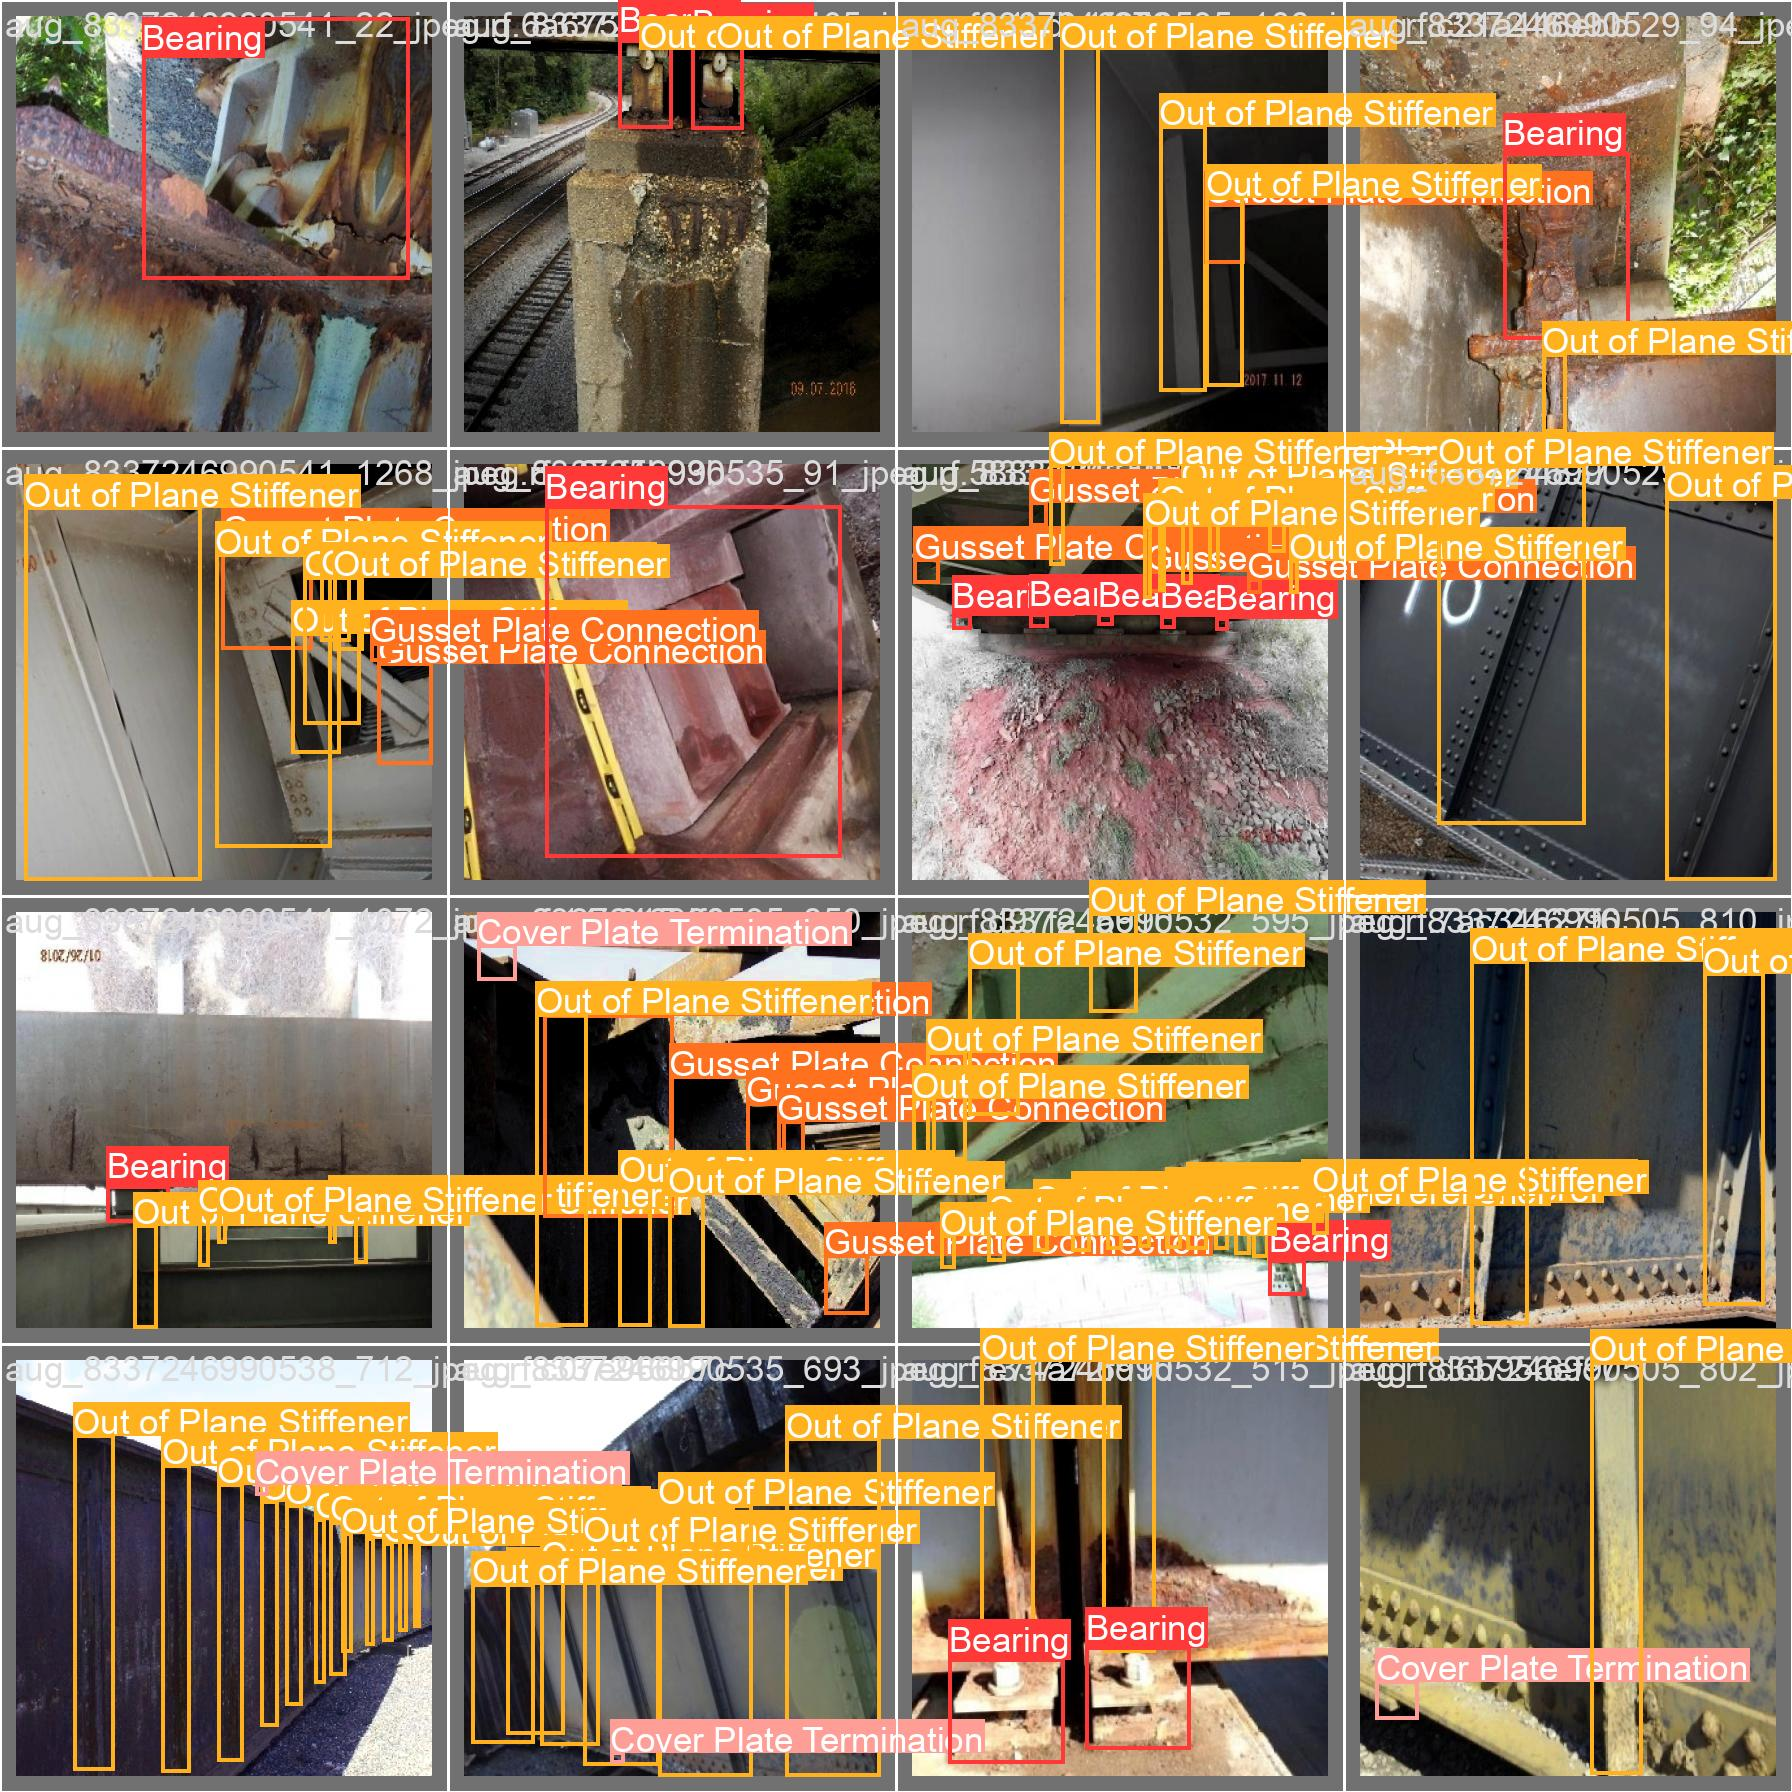

In [ ]:
import glob
from IPython.display import Image, display
Image(filename=f"/content/yolov9/runs/train/exp3/val_batch1_labels.jpg", width=700)